# SWEET OR SOUR: Diabetes Prediction on Female 

### Disclaimer
Initially, my research proposal focused on predicting early symptoms of diabetes. However, further investigation led me to realize that my original topic was too broad, prompting me to narrow it down. Therefore, I decided to shift the focus of my study to predicting diabetes specifically in females.

# INTRODUCTION

Diabetes is one of the most common human diseases and has become a significant public health concernaround the world. The research from Centers for Disease Control and Prevention (2022) found that diabetes increases the risk of heart disease (the most common diabetes complication) by about four times in women but only about two times in men. 

Accordingly, this project then aims to drive deep in Diabetes Prediction on Female based on certain diagnostic measurements included in the dataset. That is because when detected early, may prevent the progression of the disease and avoid other complications. 

Moreover, this project will use two of prediction methods, which are logistic regression and random forest. Then, we will determine what model suits best for our project and what are the features will be used in the prediction model.

# GET TO KNOW OUR DATA

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics,metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [2]:
def expit(my_x): # this is also available as scipy.special.expit()
    return 1/(1+np.exp(-my_x))

In [3]:
file = '/Users/mudmi/Desktop/Data Sci/datasci project/diabetes.csv'
df = pd.read_csv(file)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases, which contains:**

***Pregnancies:*** Number of times pregnant

***Glucose:*** Plasma glucose concentration a 2 hours in an oral glucose tolerance test

***BloodPressure:*** Diastolic blood pressure (mm Hg)

***SkinThickness:*** Triceps skin fold thickness (mm)

***Insulin:*** 2-Hour serum insulin (mu U/ml)

***BMI:*** Body mass index (weight in kg/(height in m)^2)

***DiabetesPedigreeFunction:*** A mathematical formula used to calculate the risk of diabetes in individuals based on their family history

***Age:*** Age (years)

***Outcome:*** Class variable (0 or 1)

# DATA CLEANING

#### Drop duplicated data

In [4]:
df = df.drop_duplicates()

#### No null values

In [5]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### See description of the dataset

In [6]:
df.describe().style.format("{:.1f}")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0,768.0
mean,3.8,120.9,69.1,20.5,79.8,32.0,0.5,33.2,0.3
std,3.4,32.0,19.4,16.0,115.2,7.9,0.3,11.8,0.5
min,0.0,0.0,0.0,0.0,0.0,0.0,0.1,21.0,0.0
25%,1.0,99.0,62.0,0.0,0.0,27.3,0.2,24.0,0.0
50%,3.0,117.0,72.0,23.0,30.5,32.0,0.4,29.0,0.0
75%,6.0,140.2,80.0,32.0,127.2,36.6,0.6,41.0,1.0
max,17.0,199.0,122.0,99.0,846.0,67.1,2.4,81.0,1.0


#### A helper function that return 4 different plots of one feature colunm 

In [7]:
def diagnostic_plots(df, variable,target):

    # Define figure size.
    plt.figure(figsize=(20, 7))

    # histogram
    plt.subplot(1, 4, 1)
    sns.histplot(df[variable], kde = True,color='dodgerblue')
    plt.title('Histogram')


    # scatterplot
    plt.subplot(1, 4, 2)
    plt.scatter(df[variable],df[target],color = 'dodgerblue')
    plt.title('Scatterplot')
    
    
    # boxplot
    plt.subplot(1, 4, 3)
    sns.boxplot(y=df[variable],color = 'dodgerblue')
    plt.title('Boxplot')
    
    # barplot
    plt.subplot(1, 4, 4)
    sns.barplot(x = target, y = variable, data = df, palette = ['dodgerblue','lightskyblue'])   
    plt.title('Barplot')
    
    
    plt.show()


#### Plot histogram, boxplot and barplot for each of features

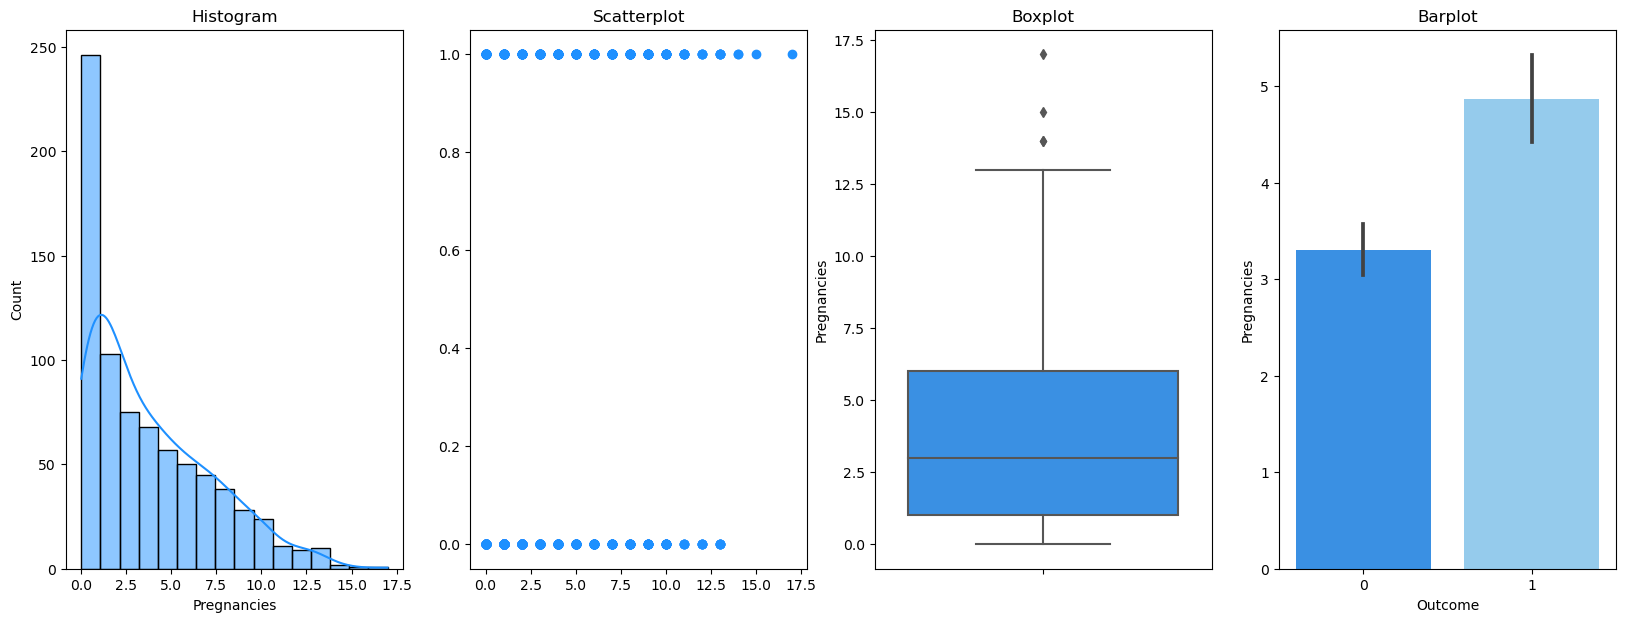

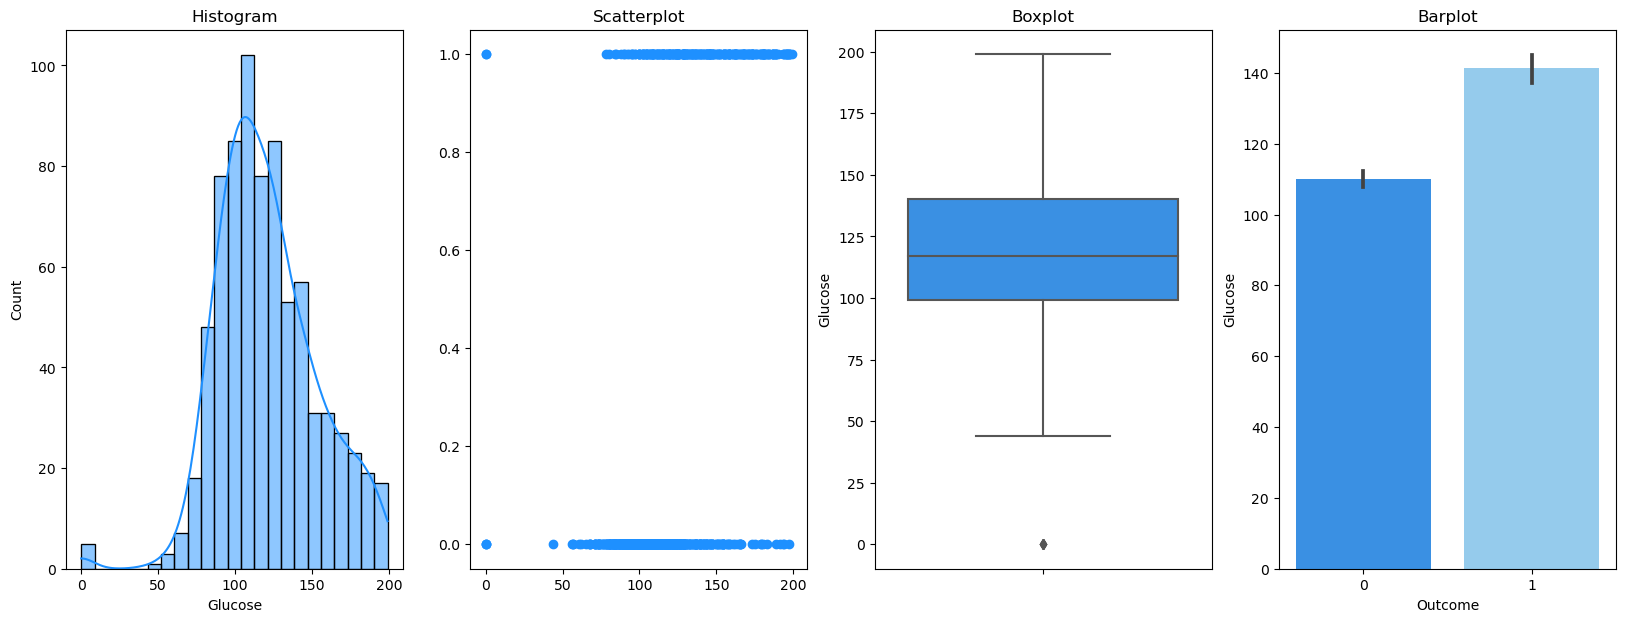

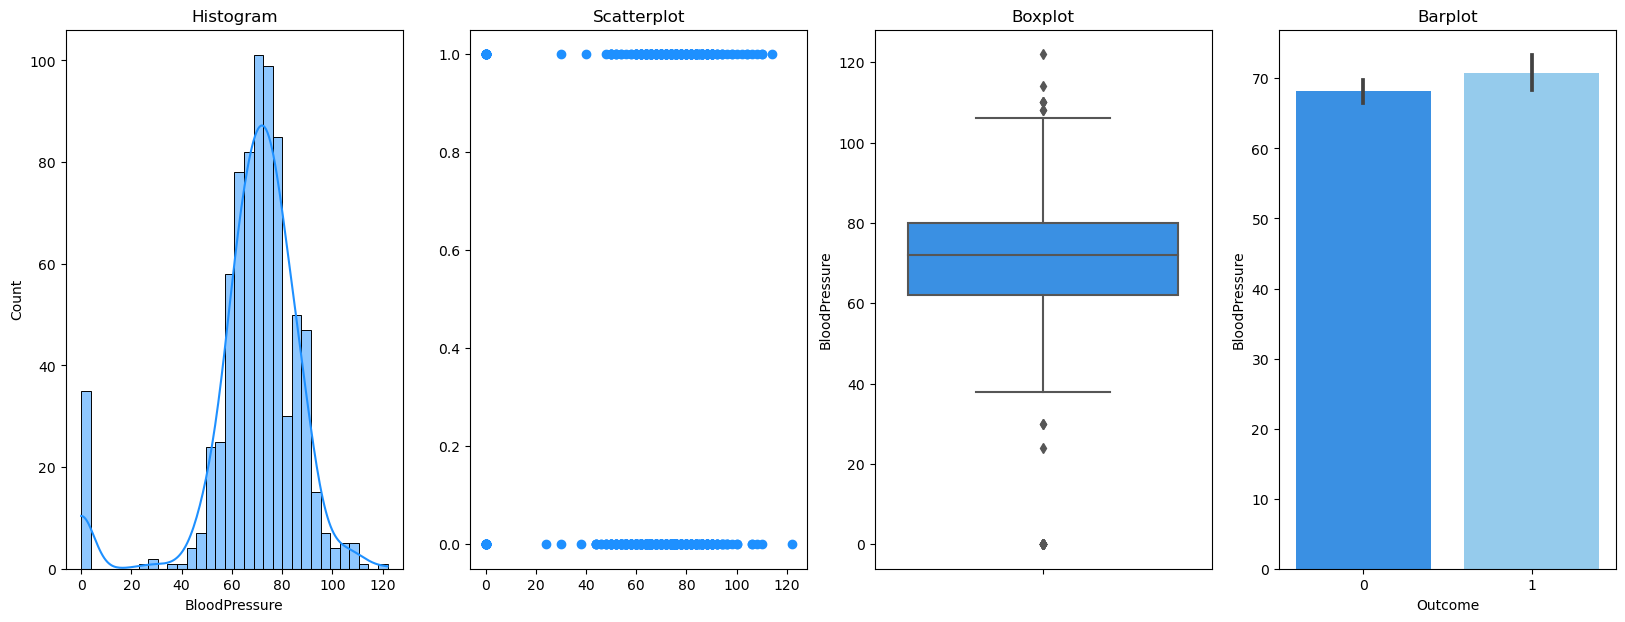

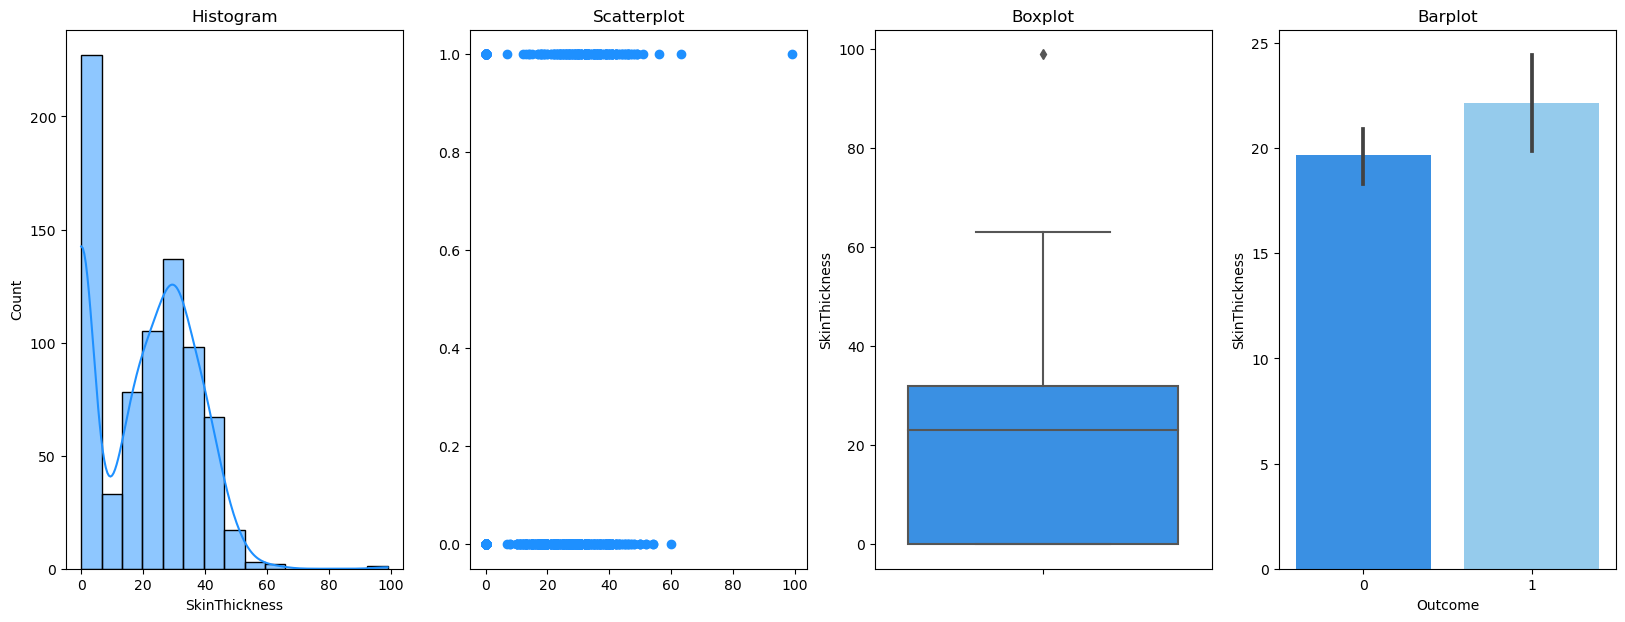

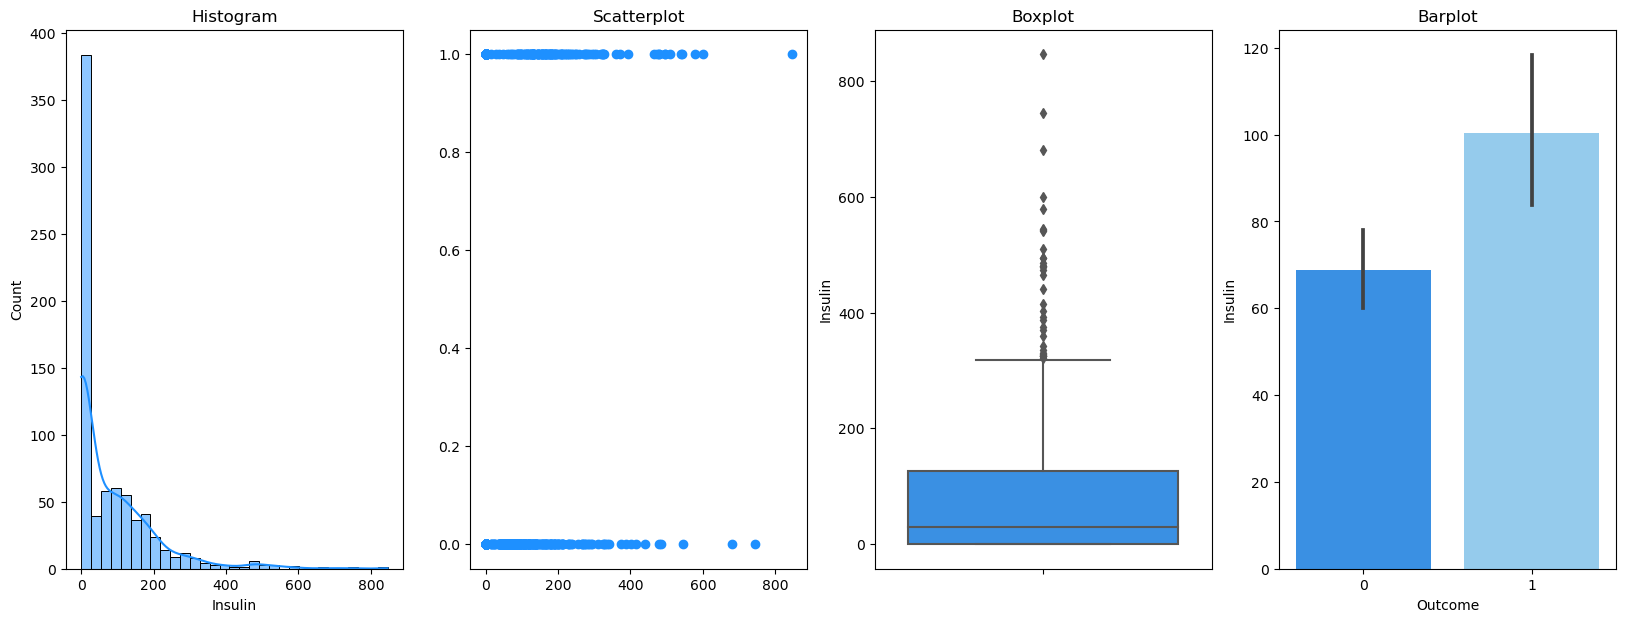

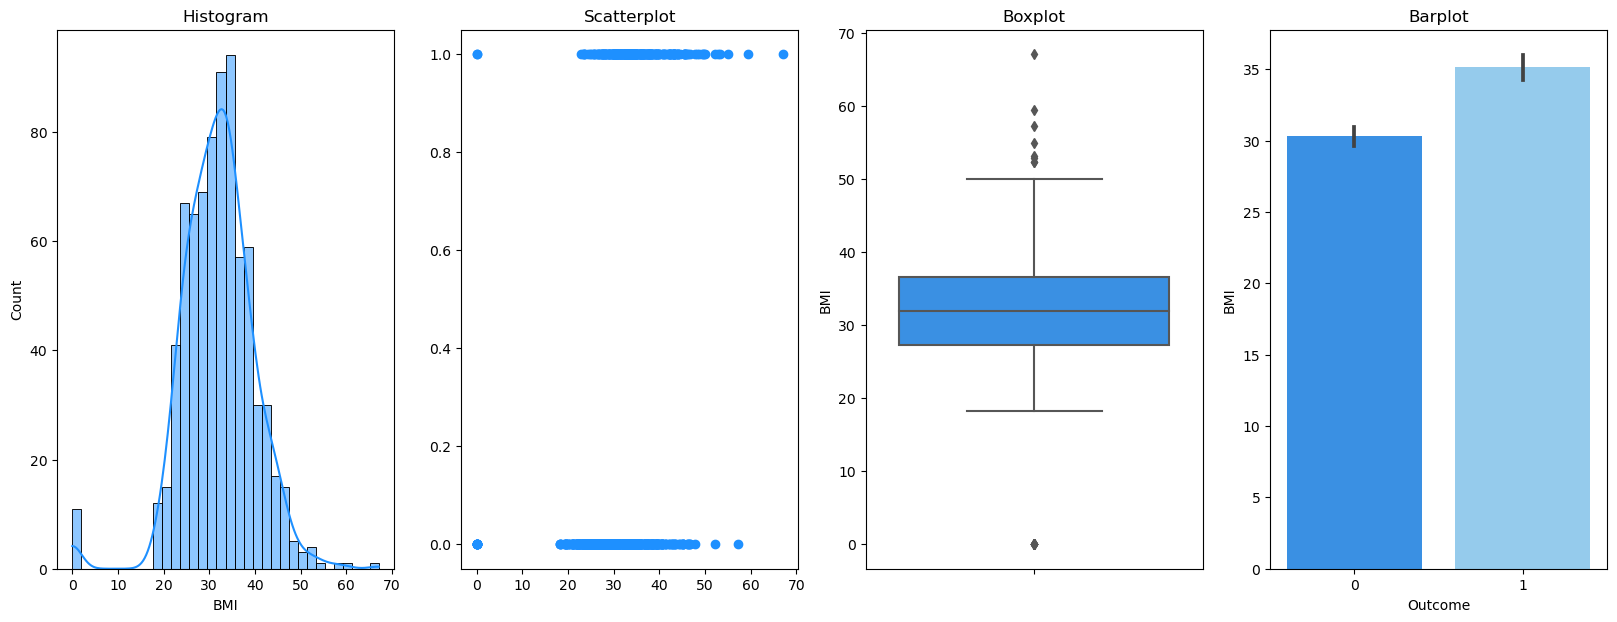

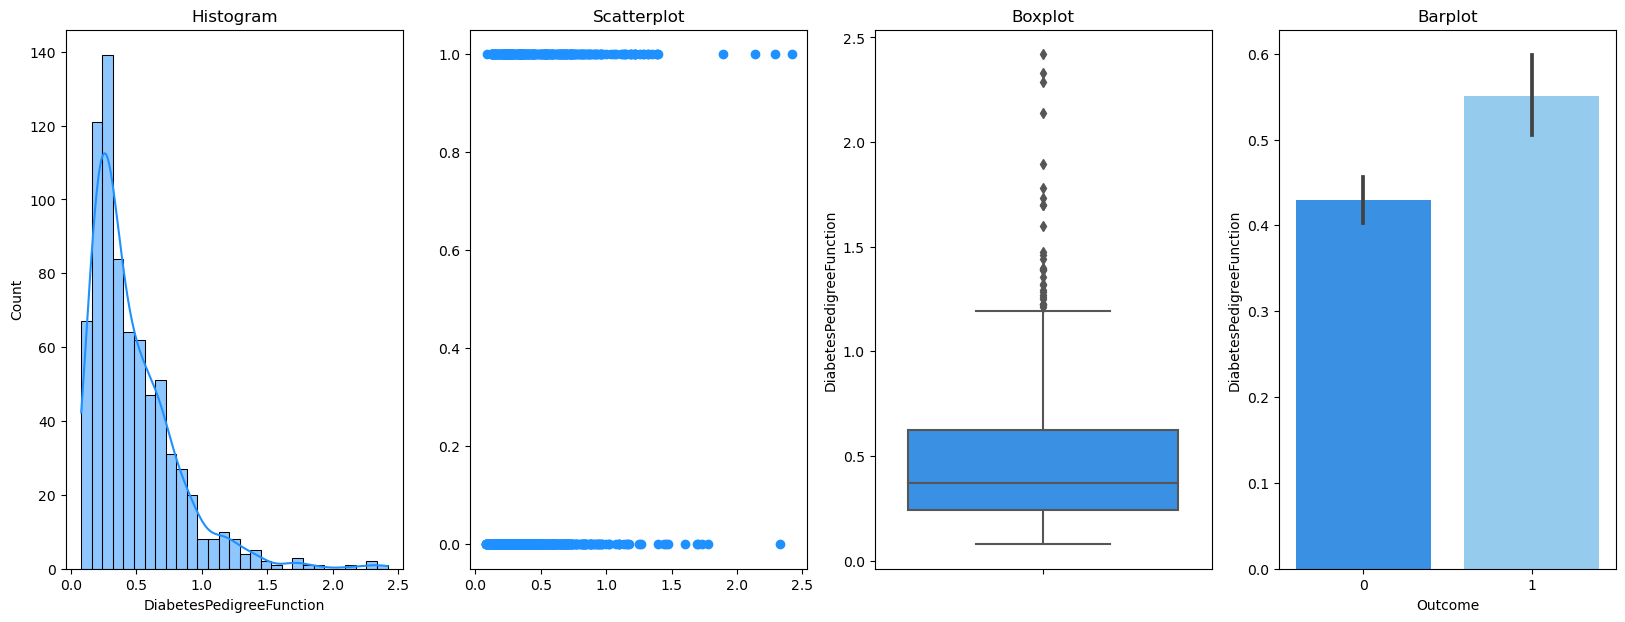

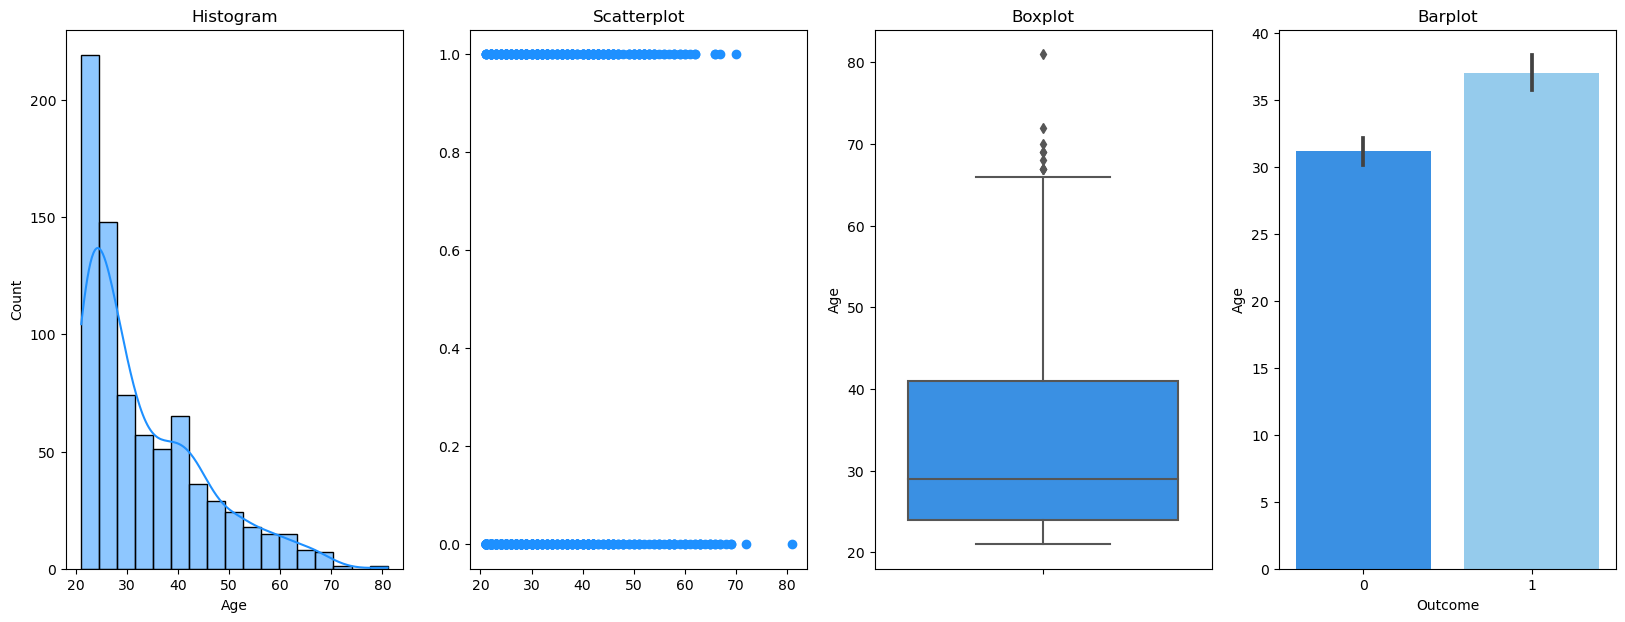

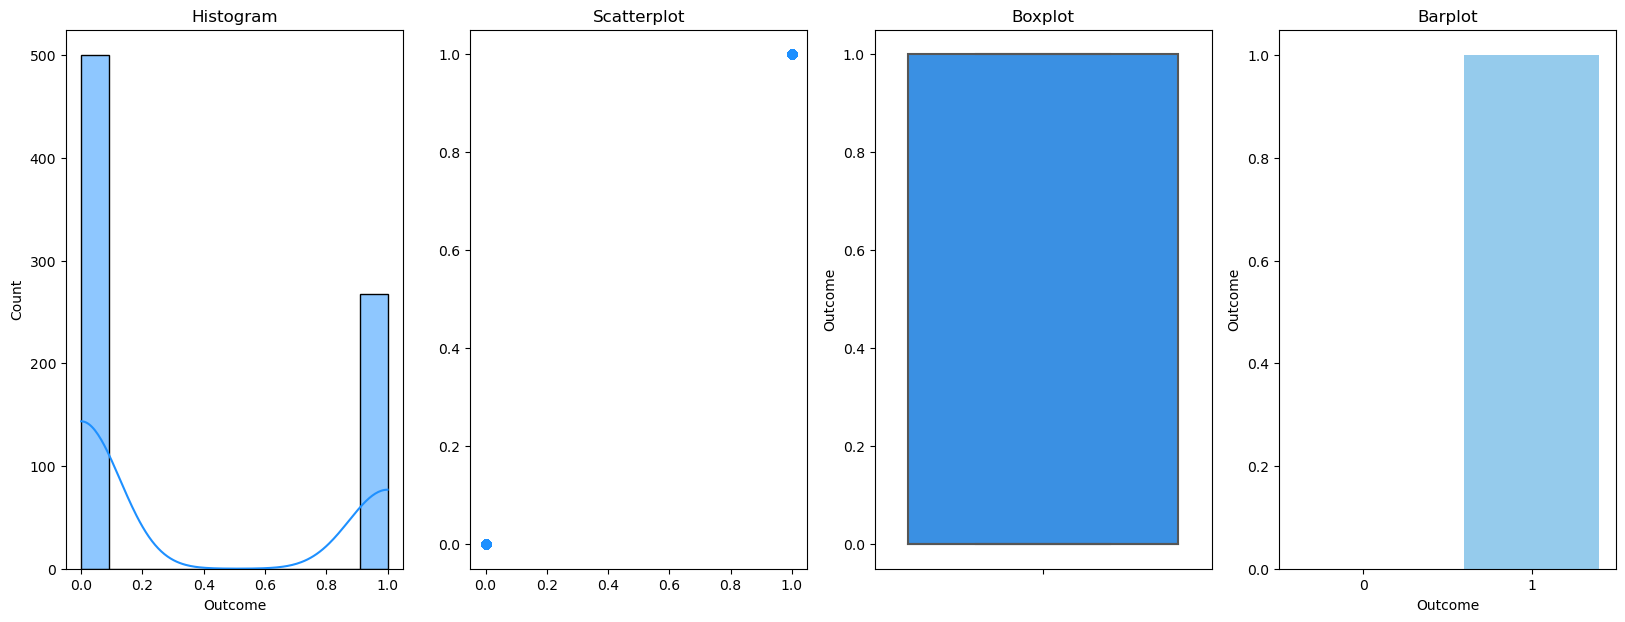

In [8]:
for col in df:
    diagnostic_plots(df,col,'Outcome')

***Outlier Boxplot Discussion***
- Pregnancy - it's possible that a woman can give birth up to 17 children but rare **need to be removed**
- Glucose - glucose level can't be zero **need to be removed**
- Blood pressure - it's possible to have high blood pressure **only outlier lower than lower quartile need to be removed**
- Skin thickness - far from upper quartile **need to be removed**
- Insulin - should be no more than 400 mIU/L  **need to be removed**
- BMI - can not be 0 so **only outlier lower than lower quartile need to be removed**
- Diabetes pedigree function - It's depends on family history
- Age - it's possible to age up to 80

#### Count value 0  in each column

In [9]:
cols= df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]
for col in cols:
    values = len(df[df[col] == 0])
    print("Number of value 0 in {} are {}".format(col,values))

Number of value 0 in Glucose are 5
Number of value 0 in BloodPressure are 35
Number of value 0 in SkinThickness are 227
Number of value 0 in Insulin are 374
Number of value 0 in BMI are 11


- All above column should not start at 0, let's replace with its median

#### replace value from the dataset that contains 0 to its median

In [10]:
cols= df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]
for col in cols:
    median = df[col].median()
    df.loc[df[col]==0,col] = median

#### Count value 0  in each column  (After adjusting)

In [11]:
cols= df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']]
for col in cols:
    values = len(df[df[col] == 0])
    print("Number of value 0 in {} are {}".format(col,values))

Number of value 0 in Glucose are 0
Number of value 0 in BloodPressure are 0
Number of value 0 in SkinThickness are 0
Number of value 0 in Insulin are 0
Number of value 0 in BMI are 0


*No more zero values inside the datasets*

#### A helper function that modify the outlier of the features

In [12]:
def mod_outlier(df):
        df1 = df.copy()
        df = df._get_numeric_data()
        q1 = df.quantile(0.25)
        q3 = df.quantile(0.75)

        iqr = q3 - q1

        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)


        for col in df.columns:
            #no need to delete  outliers from these features
            if col == "DiabetesPedigreeFunction" or col == "Age":
                continue
            
            for i in range(0,len(df[col])):
                if df[col][i] < lower_bound[col]:            
                    df[col][i] = lower_bound[col]
                if df[col][i] > upper_bound[col] and col != "BloodPressure" and col != "BMI":
                    df[col][i] = upper_bound[col]    

        for col in df.columns:
            df1[col] = df[col]

        return(df1)

#### Save the modified data in clean_df

In [13]:
clean_df = mod_outlier(df)

/var/folders/r8/k6zk4ly918gdqbn7xzyr39800000gn/T/ipykernel_83503/1303857895.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = upper_bound[col]
/var/folders/r8/k6zk4ly918gdqbn7xzyr39800000gn/T/ipykernel_83503/1303857895.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = lower_bound[col]


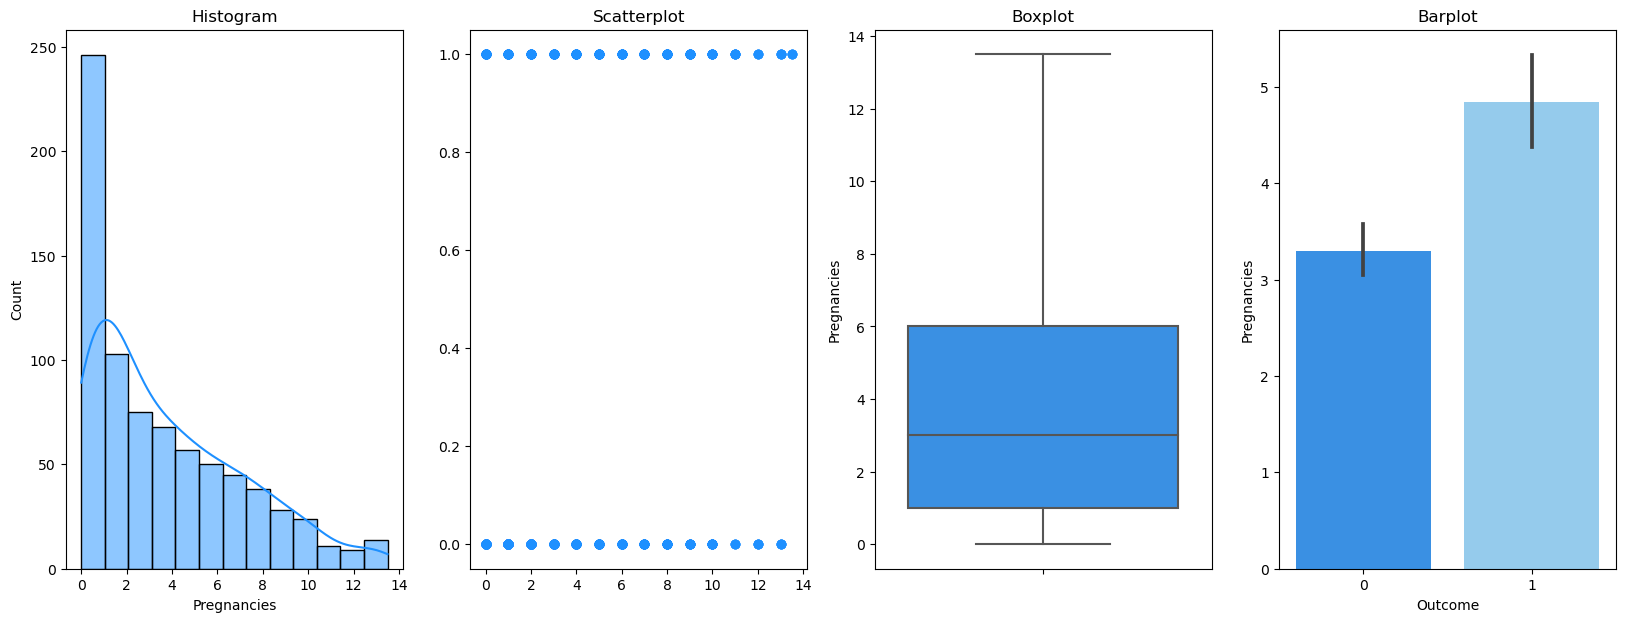

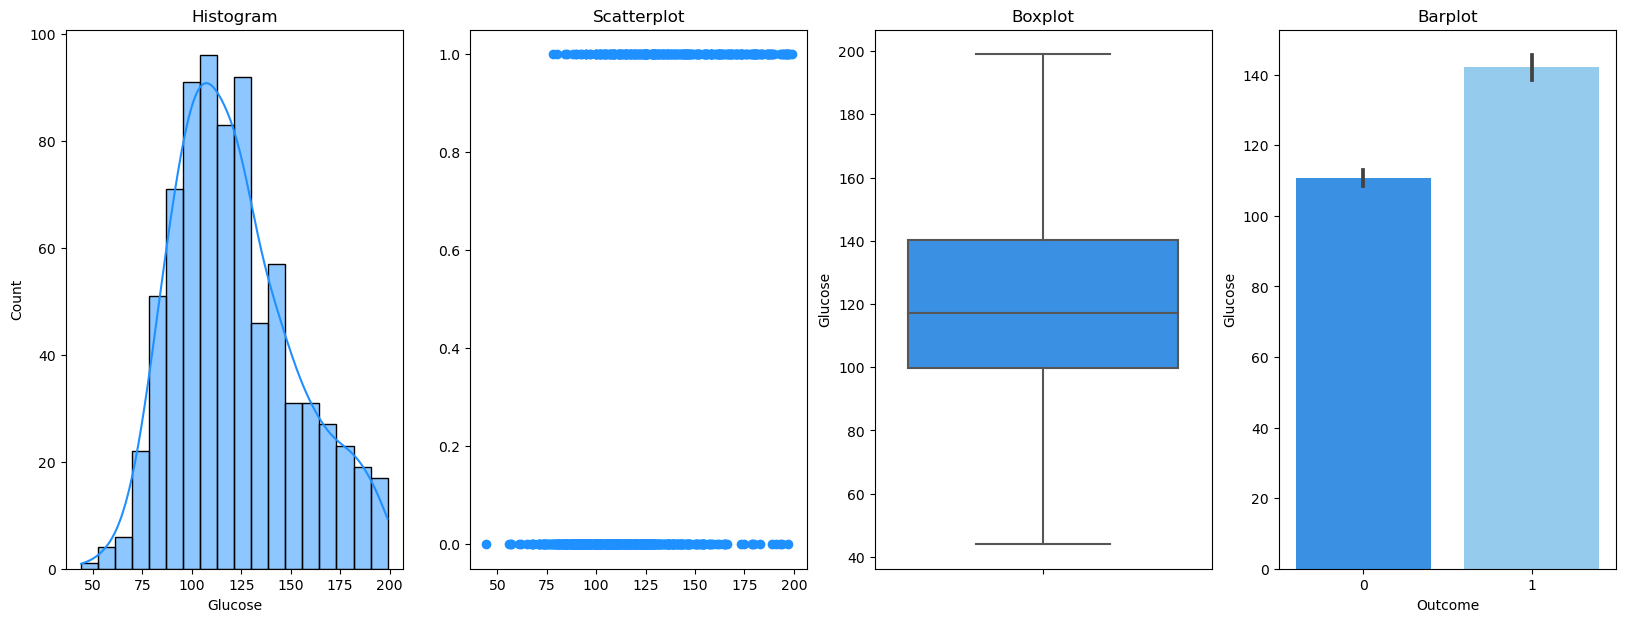

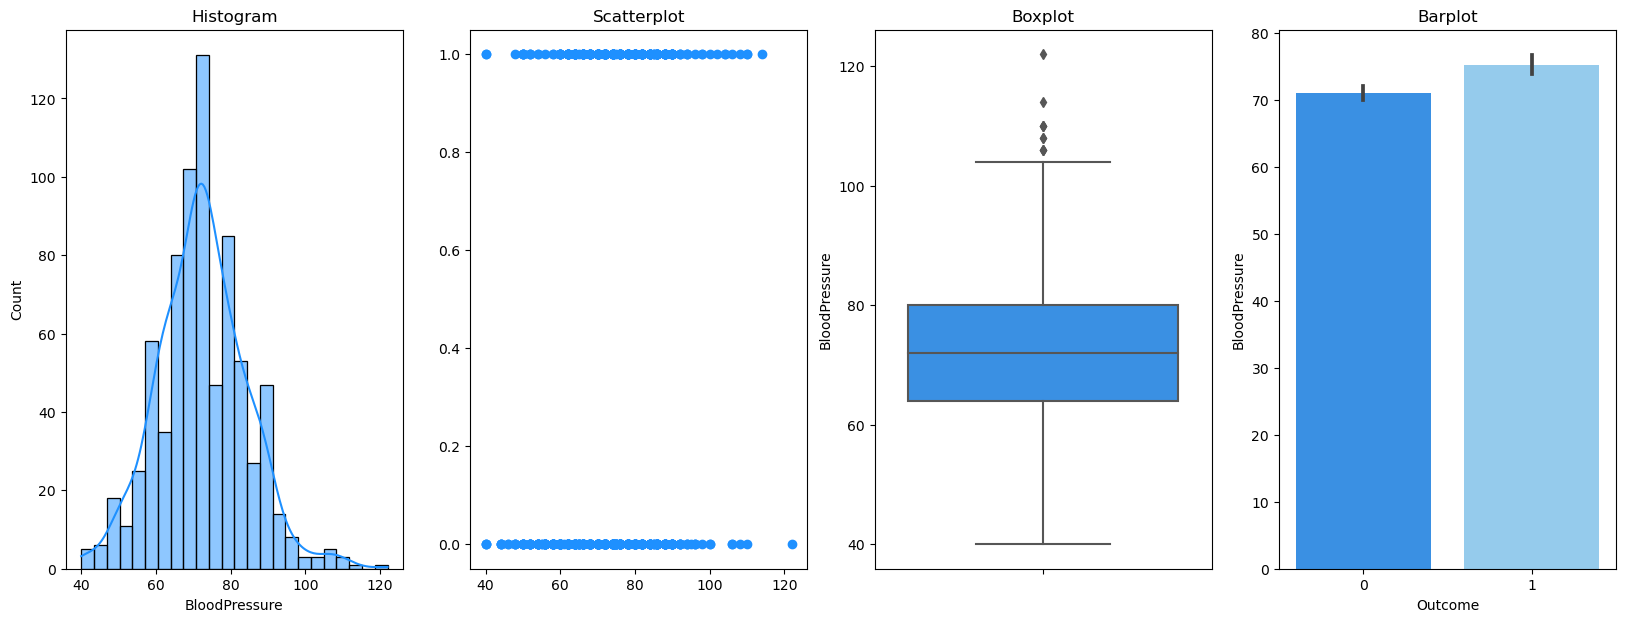

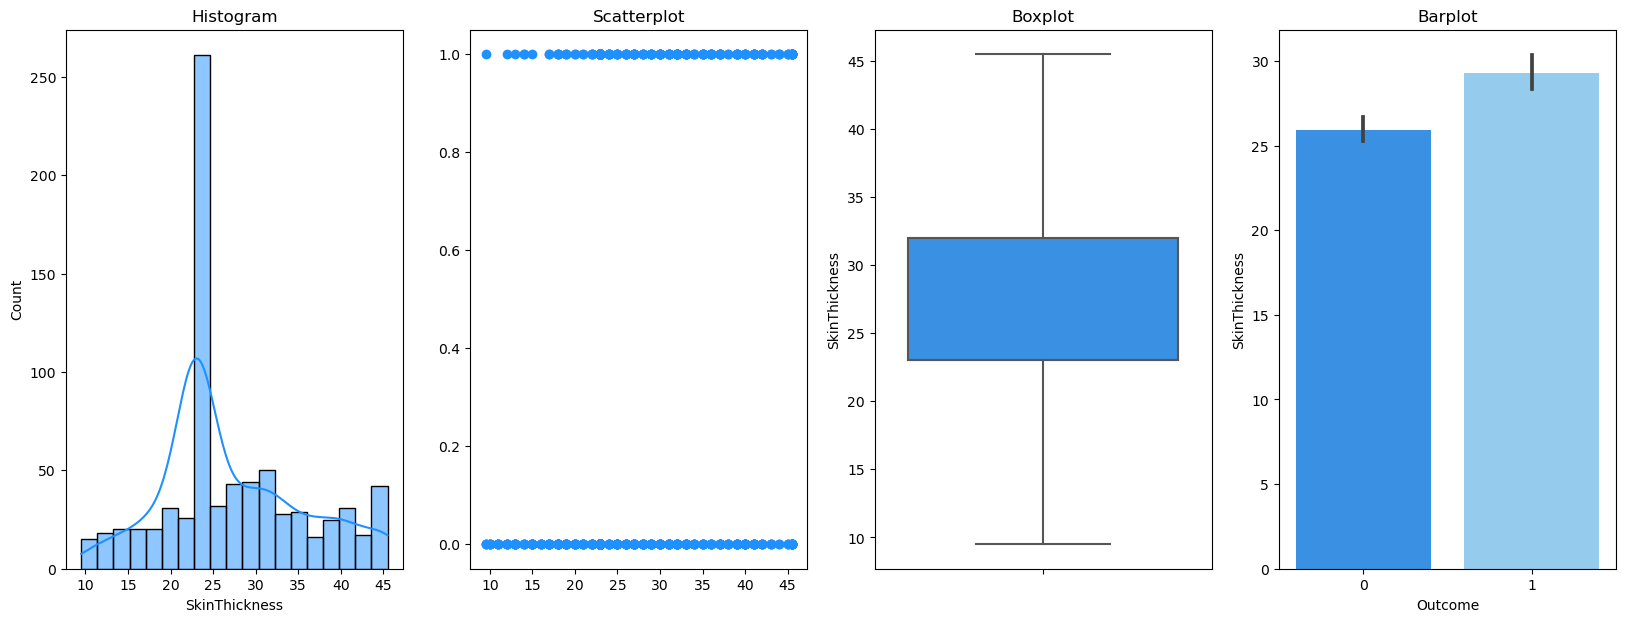

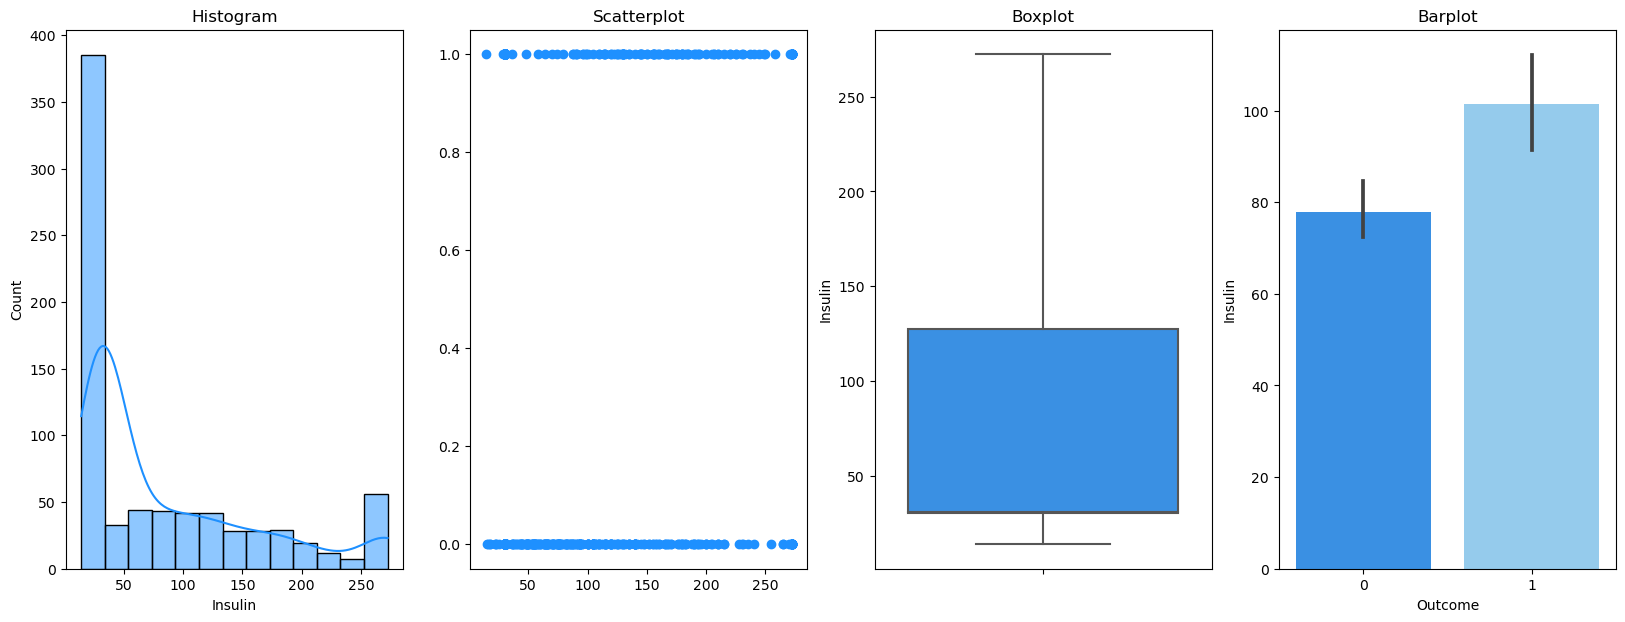

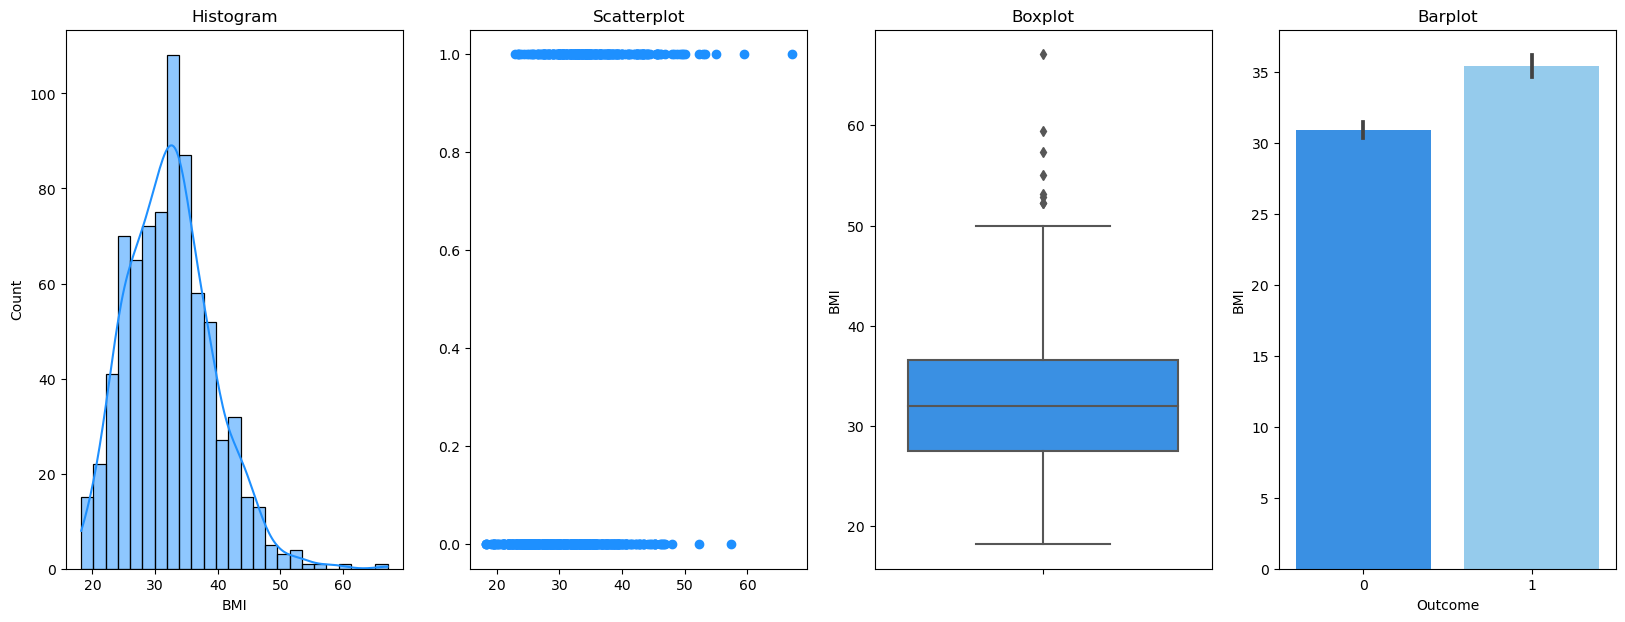

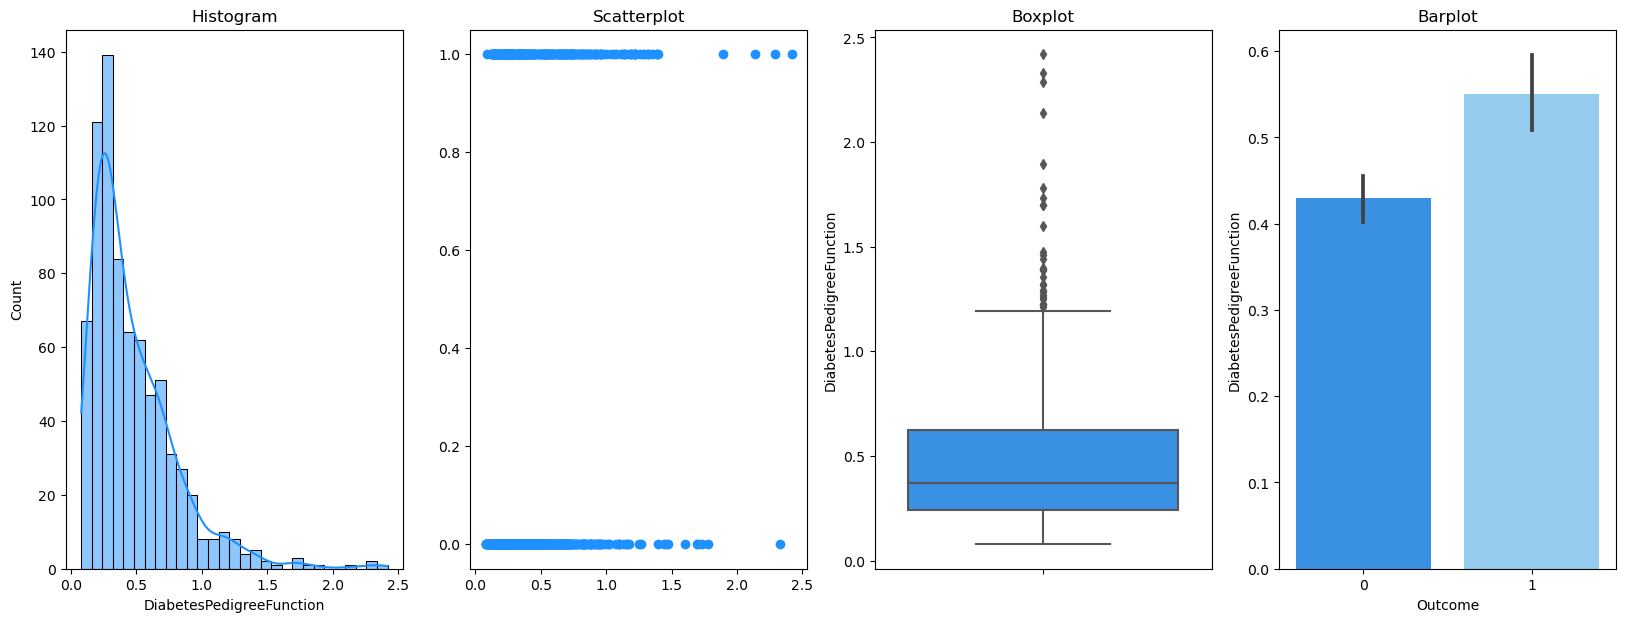

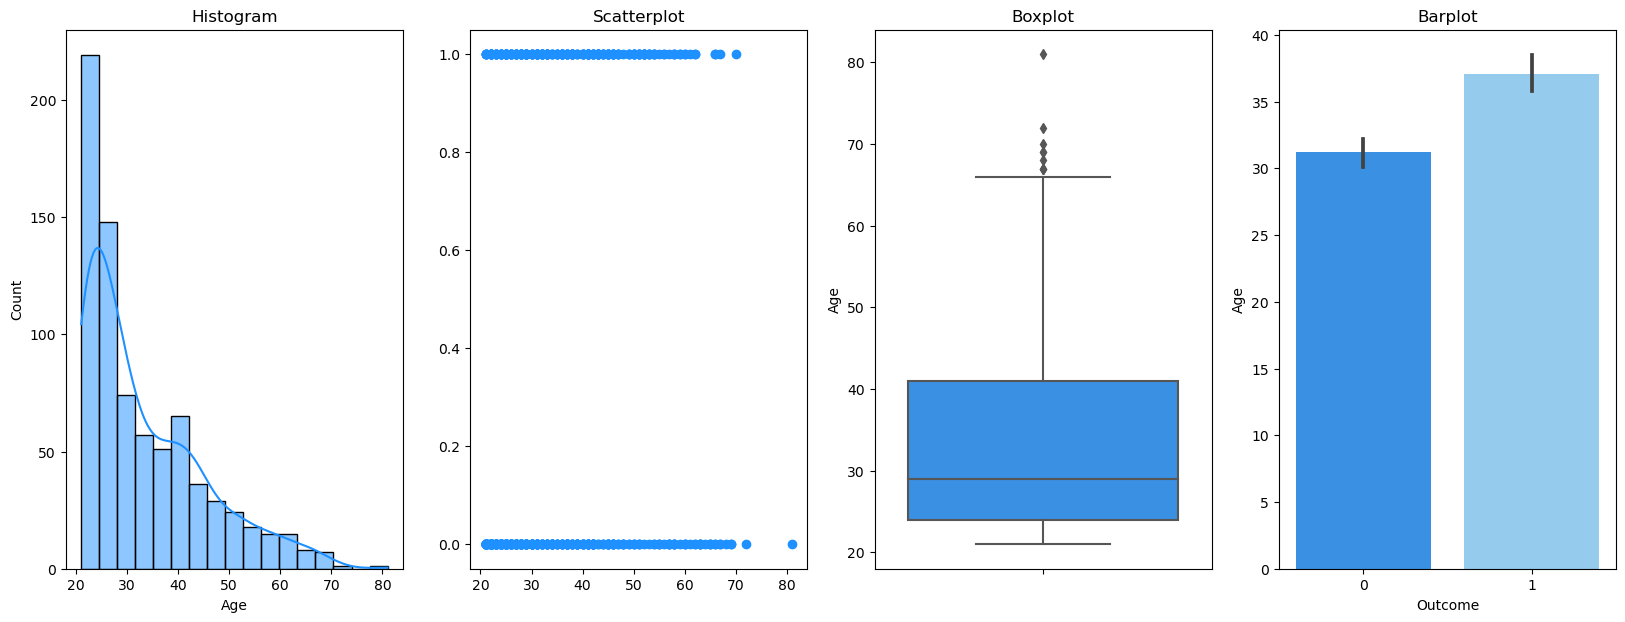

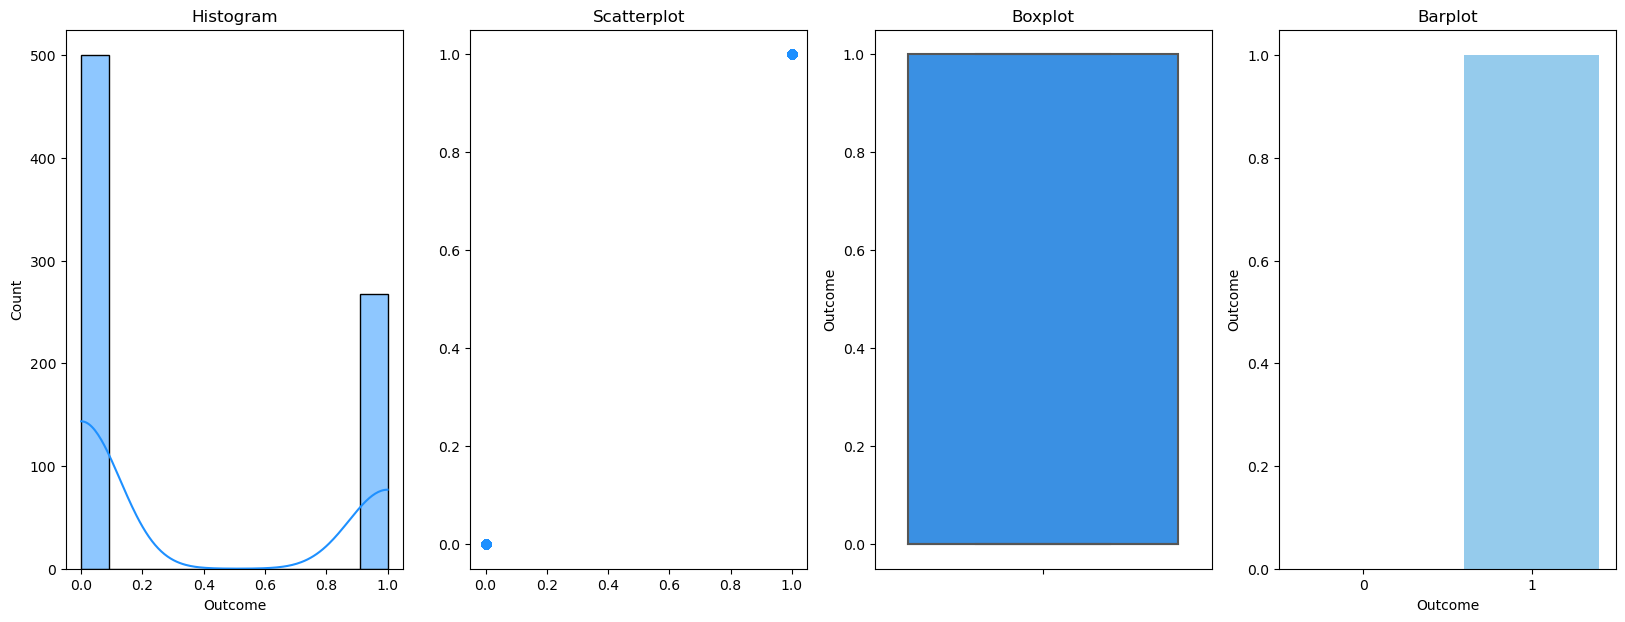

In [14]:
for col in clean_df:
    diagnostic_plots(clean_df,col,'Outcome')

#### Some of outliers have been removed as stated previously
So now we got some clean data ready to be used!

# EXPLORATORY DATA ANALYSIS 

In [15]:
clean_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148,72,35.0,30.5,33.6,0.627,50,1
1,1.0,85,66,29.0,30.5,26.6,0.351,31,0
2,8.0,183,64,23.0,30.5,23.3,0.672,32,1
3,1.0,89,66,23.0,94.0,28.1,0.167,21,0
4,0.0,137,40,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101,76,45.5,180.0,32.9,0.171,63,0
764,2.0,122,70,27.0,30.5,36.8,0.340,27,0
765,5.0,121,72,23.0,112.0,26.2,0.245,30,0
766,1.0,126,60,23.0,30.5,30.1,0.349,47,1


## Find the Correlation

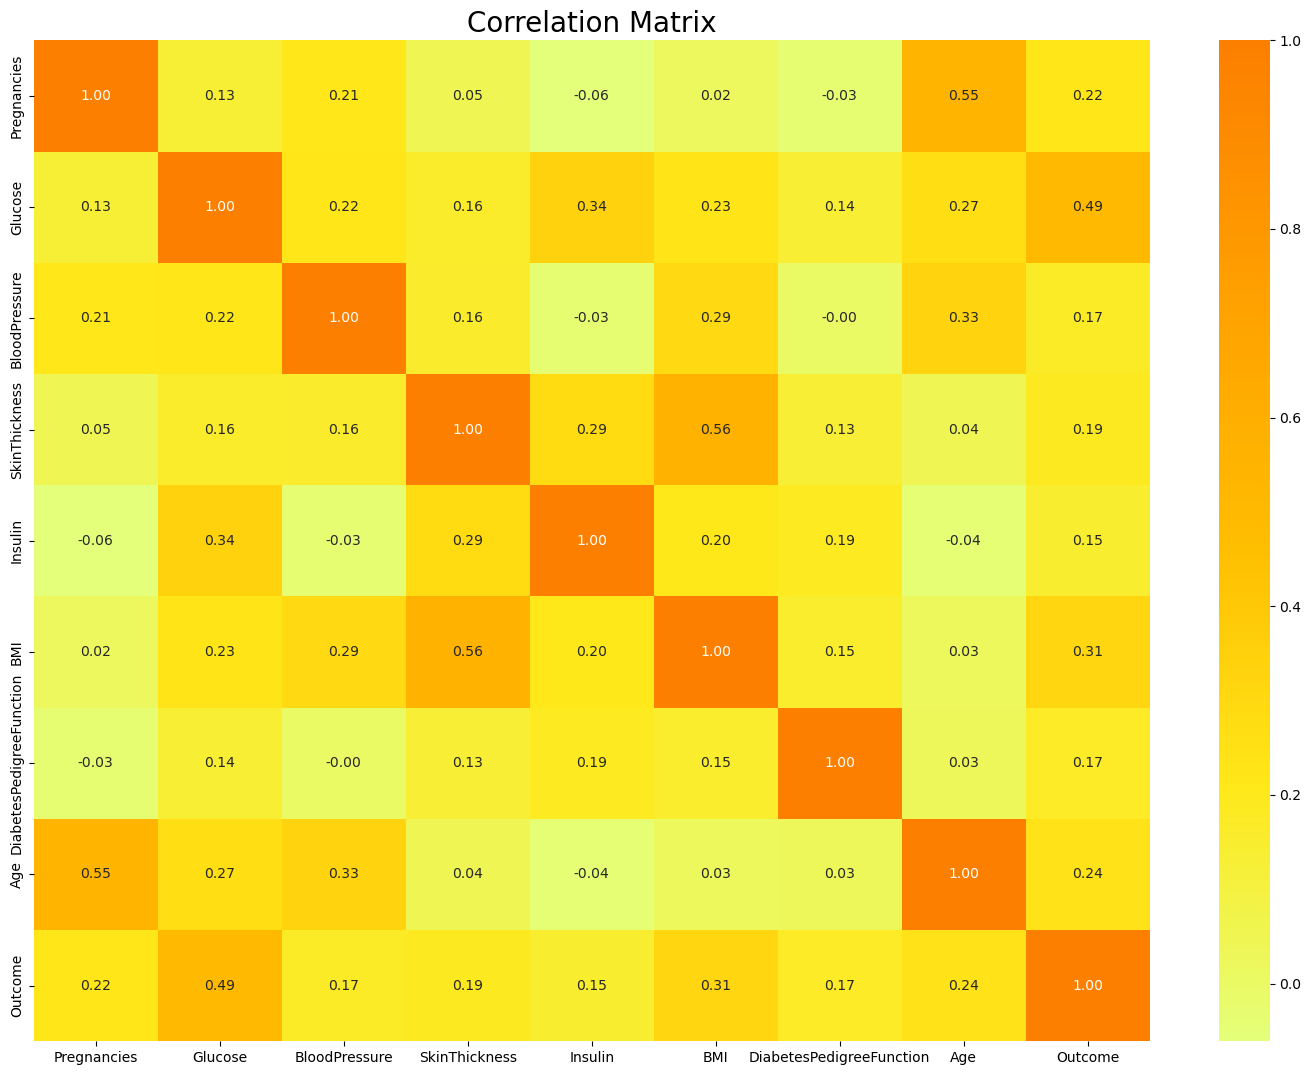

In [16]:
# Correlation matrix
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(clean_df.corr(), annot=True, fmt=".2f", ax=ax, cmap = "Wistia") 
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

#### Let's read from the outcome column with sorted range from the most correlation to least

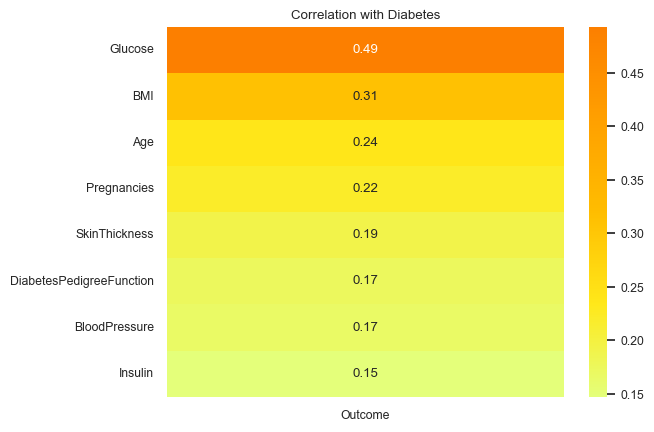

In [17]:
corr = clean_df.corr()
target_corr = corr['Outcome'].drop('Outcome')
target_corr_sorted = target_corr.sort_values(ascending=False)
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap = "Wistia", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

Let's pick some of the features from most correlated to least. Then put them in the model to make sure that we pick the right features for our prediction.

In [29]:
# X = clean_df[["Pregnancies","SkinThickness","Glucose","Age","BloodPressure","Insulin","BMI","DiabetesPedigreeFunction"]]
X = clean_df[["Glucose","BMI","Age","Pregnancies"]]
# X = clean_df[["Glucose","Age","BloodPressure","Insulin","BMI","DiabetesPedigreeFunction"]]

y = clean_df.Outcome

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (614, 4)
y_train shape: (614,)
X_test shape: (154, 4)
y_test shape: (154,)


In [20]:
model = sm.Logit(y, X)
result = model.fit()
beta = result.params #use for example
result.summary()

Optimization terminated successfully.
         Current function value: 0.636251
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      764
Method:                           MLE   Df Model:                            3
Date:                Wed, 12 Jul 2023   Pseudo R-squ.:                 0.01631
Time:                        15:33:40   Log-Likelihood:                -488.64
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                  0.001031
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Glucose         0.0135      0.003      5.248      0.000       0.008       0.019
BMI            -0.0484      0.009     -5.322      0.000      -0.066      -0.031
Age            -0.0303      0.008     -3.760      0.000      -0.046      -0.015
Pregnancies     0.1195      0.028      4.283      0.000       0.065       0.174
===============================================================================
"""

By only having "Glucose","BMI","Age" and "Pregnancies" as prediction features, each P-Value is less than the significance level (usually 0.05) then the model fits the data well

# PREDICTION MODELS

## 1) Logistic Regression

/Users/mudmi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


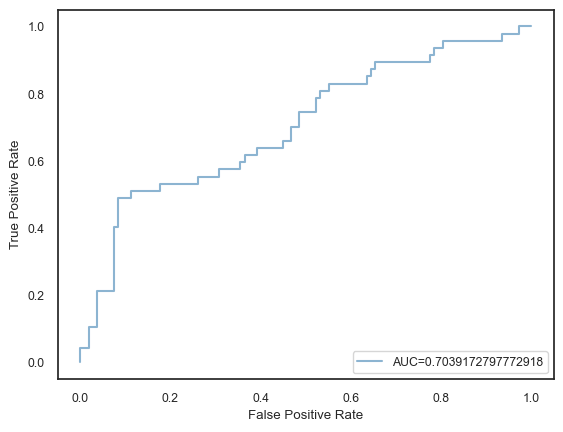

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics,metrics

#instantiate the model
clf = LogisticRegression(max_iter=100,multi_class="ovr",penalty="l1",solver="saga")
#fit the model using the training data
clf.fit(X_train,y_train)

#define metrics
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

        # score = metrics.accuracy_score(y_test,y_pred)
        # print ("with solver saga score is : {}".format(score))

### AUC = 0.70

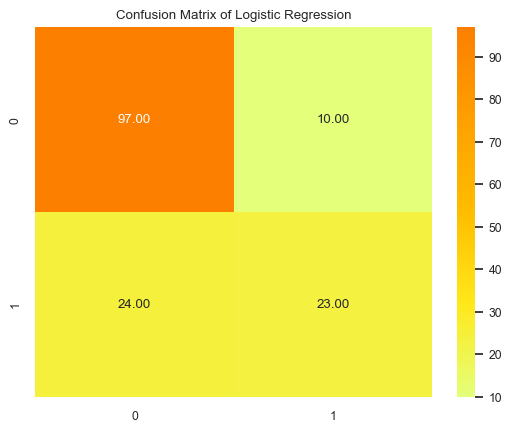

In [22]:
ConfusionMetric = metrics.confusion_matrix(y_test,y_pred)

sns.heatmap(ConfusionMetric,annot=True,fmt=".2f", cmap = "Wistia")
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

The confusion matrix above shows the prediction summary of the model.

- **TP = 97** Diabetic patients are correctly diagnosed with diabetes

- **TN = 23** Non-Diabetic patients are correctly diagnosed with non-diabetes

- **FP = 24** Non-Diabetic patients are incorrectly diagnosed as diabetes

- **FN = 10** Diabetic patients are incorrectly diagnosed as non-diabetes

### Example of Prediction 

In [23]:
# "Glucose","Pregnancies","BMI","Age"
age = 35
BMI = 30.5
pregnancies = 6
glucose = 130
patient = np.array([[glucose,BMI,age,pregnancies]])
clf.predict(patient)

/Users/mudmi/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0])

In [24]:
clf.predict_proba(patient)

/Users/mudmi/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.51611668, 0.48388332]])

The prediction rate shows that 51.6% non-diabetes and 48.4% might be diabetes

## 2) Random Forest Model

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier() 
_ = rf_model.fit(X_train, y_train)
rf_yhat = rf_model.predict(X_test)
accuracy_score(rf_yhat, y_test)

0.8311688311688312

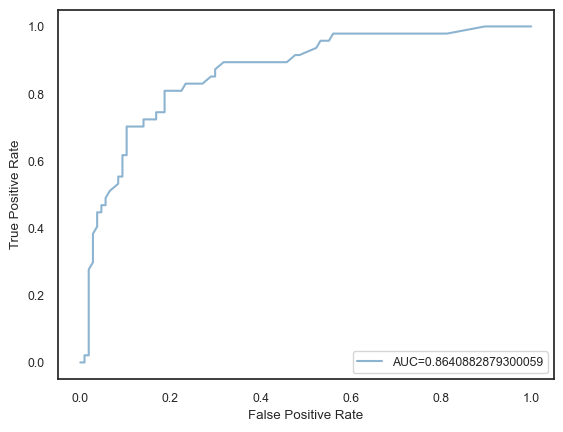

In [26]:
#define metrics
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
# auc = metrics.roc_auc_score(rf_yhat, y_test)

#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### AUC = 0.86

### Example of Prediction 

In [27]:
# "Glucose","BMI","Age","Pregnancies"

age = 35
BMI = 30.5
pregnancies = 6
glucose = 130
patient = np.array([[glucose,BMI,age,pregnancies]])

rf_model.predict(patient)

/Users/mudmi/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0])

The patient is predicted to have diabetes

In [28]:
rf_model.predict_proba(patient) #probabilities on both 0 and 1 of the outcome

/Users/mudmi/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.5, 0.5]])

The prediction rate shows that 38% non-diabetes and 62% might be diabetes

# DISCUSSION

## Why Random Forest Model is Better?

**Model Complexity:**
Random Forest can capture nonlinear relationships better.

**Feature Importance**
Random Forest automatically selects important features, while Logistic Regression treats all features equally.

**Outliers:**
Logistic Regression is sensitive to outliers, impacting its performance more than Random Forest.


## How to enhance the prediction accuracy?

The outcome would be more accurate with a dataset filled with accurate information. Many values are zero, indicating missing patient values. 
I had to decide whether to replace outliers and zero values with their median or remain the same, which might affect the prediction accuracy

# CONCLUSION

- Logistic Regression AUC = 0.70
- Random Forest Model AUC = 0.86


 This project will use only "Glucose","BMI", "Age" and "Pregnancies" as feature values to predict diabetes classification on female patients. Moreover, the prediction method that will be using is Random Forest, since it gives the highest AUC score, which shows a quality of model's prediction. 


# Citation

Dataset https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset/discussion

Diabetes and Women
https://www.cdc.gov/diabetes/library/features/diabetes-and-women.html#:~:text=Diabetes%20increases%20the%20risk%20of,%2C%20kidney%20disease%2C%20and%20depression.